In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#Model 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
#NLP
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
#import gensim
from gensim.models import Word2Vec
#Text processing
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

from sklearn.pipeline import Pipeline

In [2]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Robin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Robin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Robin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Robin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

<bound method NDFrame.head of                                                    text  label
0     Why did I only receive a partial amount of wha...      3
1                          my atm transaction was wrong      3
2                              why did i only get 20.00      3
3     Why is my cash request and the amount I receiv...      3
4     I tried to withdraw $100, all it gave me was $20.      3
...                                                 ...    ...
2164  Was charged an ATM fee despite it being a smal...      4
2165             I had a wrong fee charged at this ATM.      4
2166  When I got cash, I'm pretty sure there was a g...      4
2167  My account got charged for taking out cash, wh...      4
2168                Why is there a fee for withdrawing?      4

[2169 rows x 2 columns]>
text     0
label    0
dtype: int64
0    227
1    222
2    221
3    220
4    217
5    215
6    213
7    212
8    211
9    211
Name: label, dtype: int64
AxesSubplot(0.125,0.11;0.775x0.77)


C:\Users\Robin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


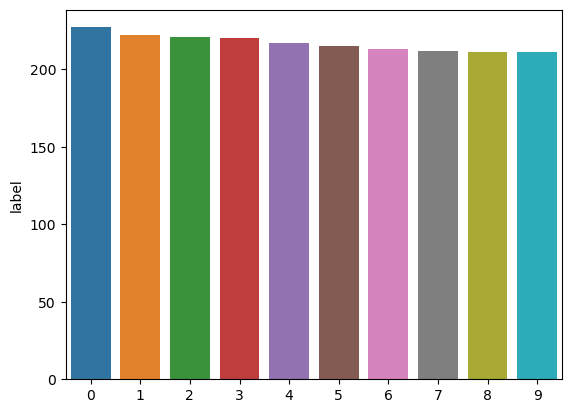

In [3]:
def load_data(csv_file,column_name):
    dataframe = pd.read_csv(csv_file)
    print(dataframe.head)
    print(dataframe.isnull().sum())
    category = dataframe[column_name].value_counts()
    print(category)
    print(sns.barplot(category.index,category))
    return(dataframe)
data_request = load_data('ds_task_dataset.csv','label')

In [4]:
#preprocessing requests
#set all letters to lower ones
def preprocess(text):
    text = text.lower() 
    text=text.strip()
    return text
#remoce usual/non relevant words
def pertinence(string):
    a= [i for i in string.split() if i not in stopwords.words('english') ]
    return ' '.join(a)
#combine these 2 functions
def preprocess_v2(string):
    return pertinence(preprocess(string))

In [5]:
#preprocessing data by add a new column : pertinent text
data_request['pertinent_text'] = data_request['text'].apply(lambda x: preprocess_v2(x))
data_request.head()

,text,label,pertinent_text
0,Why did I only receive a partial amount of wha...,3,receive partial amount tried withdraw?
1,my atm transaction was wrong,3,atm transaction wrong
2,why did i only get 20.00,3,get 20.00
3,Why is my cash request and the amount I receiv...,3,cash request amount received different?
4,"I tried to withdraw $100, all it gave me was $20.",3,"tried withdraw $100, gave $20."


In [6]:
#Create a class of  World to Vector model
# word2vec algorithm uses a neural network model to learn word associations from a large corpus of text
#word2vec represents each distinct word with a particular list of numbers called a vector.
#use the cosine similarity between the vectors to compute the level of semantic similarity of the associated words
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(next(iter(word2vec.values())))
        
        ## comply with scikit-learn transformer requirement
    def fit(self, X, y):
        return self
    #Compute average word vector for a single doc/sentence.
    #embedding of all words are averaged, and thus we get a 1D vector of features corresponding to each tweet. 
 #   ( the overall average will be a good representation of the tweet.)
    #This data format is what typical machine learning models expect
    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    # empty words
                    # If a text is empty, return a vector of zeros.
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])


#Train/test a logistic regression on the dataset
def create_model_bag_words(dataset,column_input="pertinent_text",column_predict="label",test_size_value=0.2):
    #create a test and train set
    X_train, X_test, y_train, y_test = train_test_split(dataset[column_input],
                                                        dataset[column_predict],
                                                        test_size=test_size_value,shuffle=True)
    
    #categorization model 1 : Bag-of-Words
    #Convert a collection of raw documents to a matrix of TF-IDF features.
    T_vectorizer = TfidfVectorizer(use_idf=True)
    X_train_vec_T = T_vectorizer.fit_transform(X_train) 
    X_test_vec_T = T_vectorizer.transform(X_test)
    
    #Training classification model using Logistic Regression(tf-idf)
    logistic_regression_model=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
    logistic_regression_model.fit(X_train_vec_T, y_train)  
    #Predicting label value for test dataset
    y_predict =  logistic_regression_model.predict(X_test_vec_T)
    y_prob =  logistic_regression_model.predict_proba(X_test_vec_T)[:,1]
    print(classification_report(y_test,y_predict))
    print('Confusion Matrix:',confusion_matrix(y_test, y_predict))
    return( [ T_vectorizer,logistic_regression_model ])

#Train/test a classification model World2vec on the dataset
def create_model_World_2_Vec(dataset,column_input="pertinent_text",column_predict="label",test_size_value=0.2):
     #create a test and train set
    X_train, X_test, y_train, y_test = train_test_split(dataset[column_input],dataset[column_predict],
                                                        test_size=test_size_value,shuffle=True)
    #vectorize the input values/queries
    X_train_vec= [nltk.word_tokenize(i) for i in X_train]  
    X_test_vec = [nltk.word_tokenize(i) for i in X_test]
   
    #vectorize the input column
    dataset[column_input+'_vec']=[nltk.word_tokenize(i) for i in data_request[column_input]]
    #classification_model
    classification_model = Word2Vec(dataset[column_input+'_vec'],min_count=1) 
    #world to vector
    w2v = dict(zip(classification_model.wv.index_to_key, classification_model.wv.vectors))
    modelw = MeanEmbeddingVectorizer(w2v)
    # converting requests to numerical data with Word2Vec
    X_train_vec_w2v = modelw.transform(X_train_vec)
    X_test_vec_w2v = modelw.transform(X_test_vec)
    
    #Training classification model using Logistic Regression and World_2_Vector

    logistic_regression_w2v=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
    logistic_regression_w2v.fit(X_train_vec_w2v, y_train)  
    #Predicting label value for test dataset
    y_predict = logistic_regression_w2v.predict(X_test_vec_w2v)
    y_prob = logistic_regression_w2v.predict_proba(X_test_vec_w2v)[:,1]
    print(classification_report(y_test,y_predict))
    print('Confusion Matrix:',confusion_matrix(y_test, y_predict))
    return([modelw,logistic_regression_w2v])
    

In [7]:
create_model_bag_words(data_request,column_input="pertinent_text",column_predict="label",test_size_value=0.2)

              precision    recall  f1-score   support

           0       0.93      0.97      0.95        39
           1       0.98      0.98      0.98        43
           2       1.00      0.98      0.99        54
           3       0.90      0.90      0.90        48
           4       0.89      0.87      0.88        47
           5       1.00      1.00      1.00        42
           6       0.88      0.94      0.91        49
           7       0.94      0.81      0.87        42
           8       0.93      0.87      0.90        31
           9       0.84      0.95      0.89        39

    accuracy                           0.93       434
   macro avg       0.93      0.93      0.93       434
weighted avg       0.93      0.93      0.93       434

Confusion Matrix: [[38  0  0  0  0  0  0  1  0  0]
 [ 0 42  0  0  1  0  0  0  0  0]
 [ 0  0 53  0  0  0  0  0  0  1]
 [ 0  0  0 43  1  0  4  0  0  0]
 [ 2  0  0  1 41  0  2  1  0  0]
 [ 0  0  0  0  0 42  0  0  0  0]
 [ 0  0  0  1  1  0 46  0

[TfidfVectorizer(), LogisticRegression(C=10, solver='liblinear')]

In [8]:
create_model_World_2_Vec(data_request,column_input="pertinent_text",column_predict="label",test_size_value=0.2)

              precision    recall  f1-score   support

           0       0.35      0.95      0.51        38
           1       0.56      0.89      0.69        45
           2       0.60      0.89      0.72        44
           3       0.65      0.84      0.73        43
           4       0.73      0.22      0.34        49
           5       0.69      0.55      0.61        44
           6       0.85      0.61      0.71        38
           7       0.17      0.02      0.04        42
           8       0.63      0.38      0.47        45
           9       0.71      0.48      0.57        46

    accuracy                           0.57       434
   macro avg       0.59      0.58      0.54       434
weighted avg       0.60      0.57      0.54       434

Confusion Matrix: [[36  1  0  0  0  1  0  0  0  0]
 [ 1 40  2  0  0  2  0  0  0  0]
 [ 0  1 39  1  0  0  0  0  2  1]
 [ 0  4  1 36  0  0  1  0  1  0]
 [28  0  1  4 11  1  2  1  1  0]
 [ 8 10  0  2  0 24  0  0  0  0]
 [ 7  1  1  4  1  0 23  1

 LogisticRegression(C=10, solver='liblinear')]

In [9]:
### PIPELINE = CODE PRODUCTION READY

##Creating a class with fit and transform method
class preprocessing():
    def __init__(self):
        self.n =0
    def fit(self,text,label):
        return self
    def transform(self,X):
         return np.array([
          ' '.join([i for i in word.lower().strip().split() if i not in stopwords.words("english") ])
            for word in X
        ])

class Chatbot():
    def __init__(self,pipeline,categories):
        self.pipeline = pipeline
        self.services = categories
    def fit(self,X,y):
        self.pipeline.fit(X, y)
    def predict(self,X):
        return self.pipeline.predict(X)
    def discuss(self):
        while True:
            user_input = input("Write a sentence :")
            service_user =self.pipeline.predict([user_input])
            print(f"Hello, my name is Dumb_Chatbot, the service is {self.services[int(service_user )-1]}")

In [15]:
data_sub = data_request.sample(100)
categories_list = ["direct payment","deposit","ATM","Cash","Charging fees",
 "transaction not approved","transfer fee","Transaction not complete","Transfer not shown in balance"]


c = Chatbot(Pipeline([('Pretransfo',preprocessing()),('Vectorizer',TfidfVectorizer(use_idf=True)), 
                      ('clf',LogisticRegression(C=10, solver='liblinear'))]),
   categories_list)
c.fit(data_sub["text"], data_sub["label"])

In [16]:
c.predict(['my atm transaction was wrong'])

array([6], dtype=int64)

In [ ]:
c.discuss()

In [29]:
data_request['text_vec']=[nltk.word_tokenize(i) for i in data_request["text"]]
data_request['pertinent_text_vec']=[nltk.word_tokenize(i) for i in data_request["pertinent_text"]]
w2vec = Word2Vec(data_request['pertinent_text_vec'],min_count=1) 


In [30]:

c = Chatbot(Pipeline([('Pretransfo',preprocessing()),
                      ('Vectorizer',MeanEmbeddingVectorizer(
                         dict(zip(w2vec.wv.index_to_key, w2vec.wv.vectors)) )), 
                      ('clf',LogisticRegression(C=10, solver='liblinear'))]),
   categories_list)
c.fit(data_sub["text"], data_sub["label"])

In [31]:
c.predict(['my atm transaction was wrong'])

array([5], dtype=int64)